# Test the code on Target data
March 24th

## Parsing

In [1]:
import pandas as pd
import os
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
files = consolidate_files_others('Target')

In [31]:
%%time
# parse into paragraphs
df = filenames_to_para(files)

Wall time: 40.8 s


## Preprocessing

In [5]:
%%time
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

Wall time: 24.4 s


In [6]:
# removing some words
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning", 
    "company", "mean", "wraptext", "”", '’'
]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

## filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
df = df[df["len_clean"]>10]

# removing disclaimer
df = df[df["paragraph"].map(lambda x: "The information in the transcripts" not in x)]
df = df[df["paragraph"].map(lambda x: "disclaimer" not in x.lower())]

In [7]:
# removing some paragraphs
removing_words = ["www.streetevents.com"]

mask = df["tokens_clean"].map(lambda x: removing_words[0] not in x)
df = df[mask]

# removing short paragraphs
df = df[df.len_clean > 22]

## Check omni's tag

In [84]:
# df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)
# tokens_pos = df["tokens_pos"]
# key_word = "omni"
# check = get_unique_words(tokens_pos)
# check = pd.DataFrame(check)
# check["pos"] = check.index
# check[check["pos"].map(lambda x: key_word in x[0])]

,0,pos
"(omni-channel, JJ)",10,"(omni-channel, JJ)"
"(omnichannel, NN)",10,"(omnichannel, NN)"
"(omnichannel, JJ)",4,"(omnichannel, JJ)"
"(omni-channel, NN)",3,"(omni-channel, NN)"
"(omni, JJ)",2,"(omni, JJ)"
"(omni-offering, NN)",1,"(omni-offering, NN)"
"(omni, RP)",1,"(omni, RP)"
"(omni-retail, NN)",1,"(omni-retail, NN)"
"(omni, NNS)",1,"(omni, NNS)"
"(omni-retail, JJ)",1,"(omni-retail, JJ)"


In [12]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

## LDA

In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [9]:
# prepare count vector as the input of LDA model
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 20

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
number_words = 12
# print_topics(lda, count_vectorizer, number_words)

words = count_vectorizer.get_feature_names()

# print topics and key words
for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic + 1, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 1  ====================
call            3.21%
performance      2.94%
remark          2.77%
earnings        2.60%
reminder        2.42%
conference      2.33%
provide         2.24%
investor        2.22%
share           1.81%
answer          1.75%
topic: 2  ====================
sale            4.14%
segment         3.41%
card            2.62%
increase        2.42%
credit          2.19%
point           1.83%
rate            1.73%
continue        1.47%
expect          1.35%
debit           1.17%
topic: 3  ====================
shareholder      4.83%
proposal        2.88%
corporation      1.74%
contribution      1.67%
electronics      1.62%
vote            1.37%
issue           1.32%
election        1.22%
policy          1.21%
sustainability      1.09%
topic: 4  ====================
price           2.00%
home            1.78%
start           1.39%
experience      1.38%
happen          1.10%
reaction        1.10%
service         1.08%
partner         1.03%
build           0.99%
people  

## Visualize topic distribution

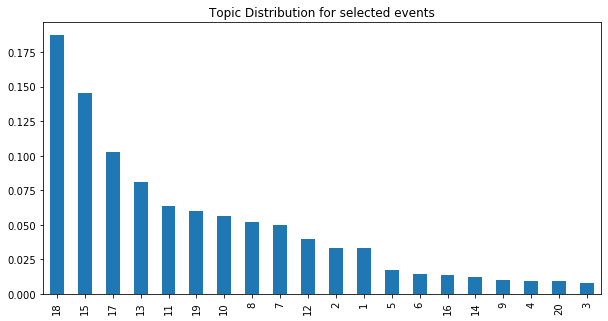

In [21]:
# assign topic to paragraphs
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

# # chech how many topics in each paragraphs
# df["number of topics"] = [sum(x>x.mean()) for x in topic_match]

topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

## Visualize paragraph counts for each year

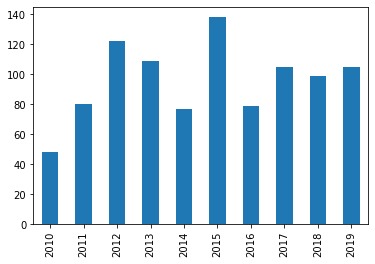

In [20]:
# df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
df['year'] = pd.PeriodIndex(df.date, freq='Y')
df["year"].value_counts().sort_index().plot(kind='bar')

## Topic trends

In [18]:
tmp = pd.crosstab(test["year"], test["topic"], normalize="index")
years = [ str(x) for x in tmp.index]

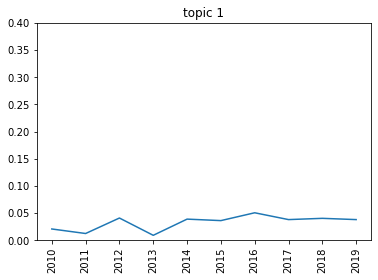

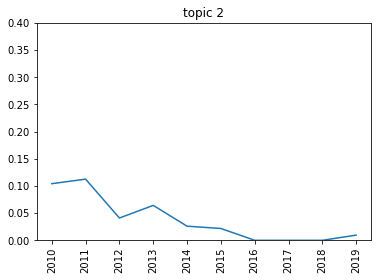

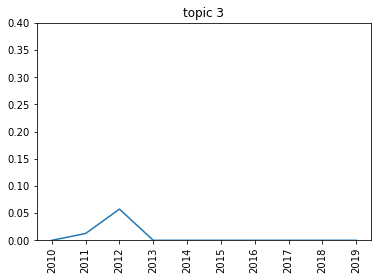

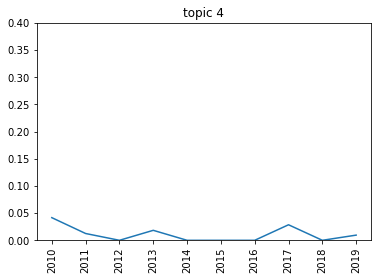

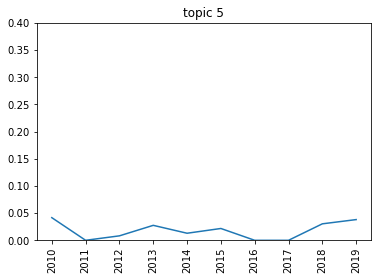

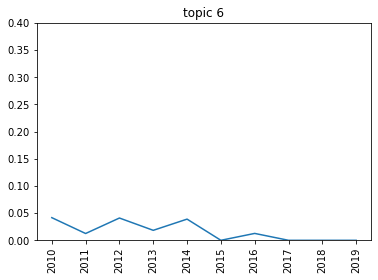

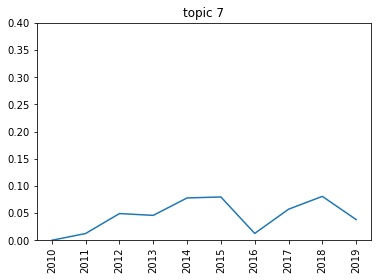

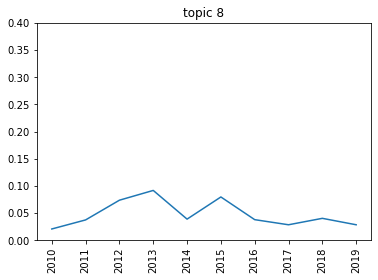

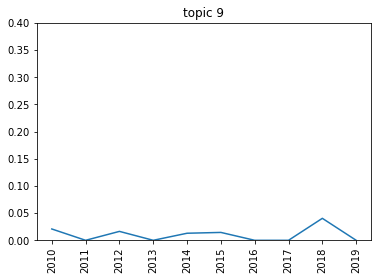

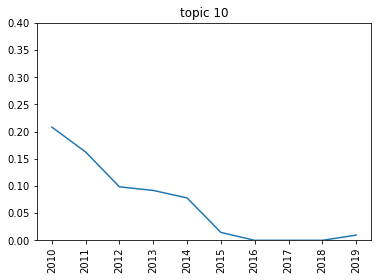

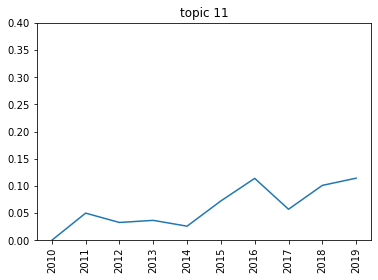

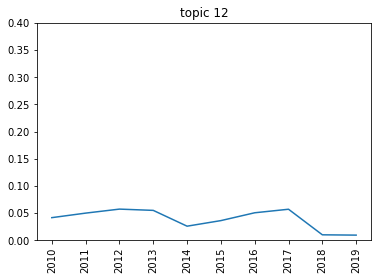

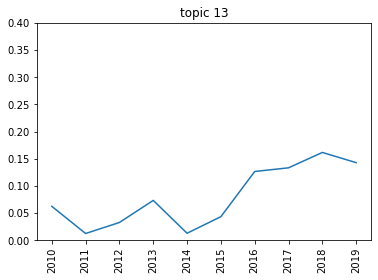

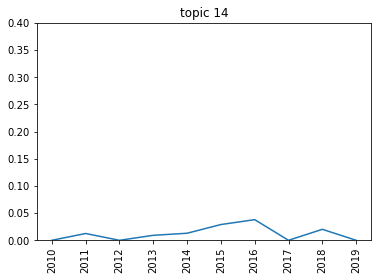

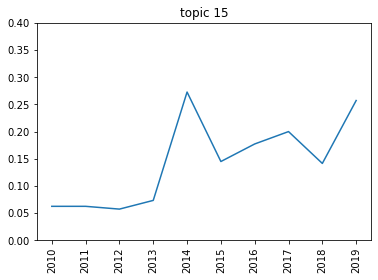

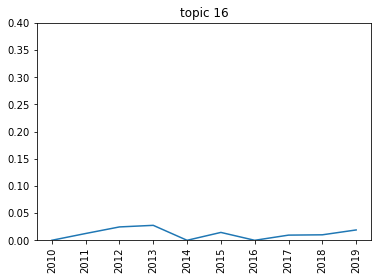

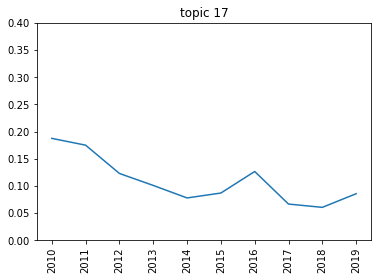

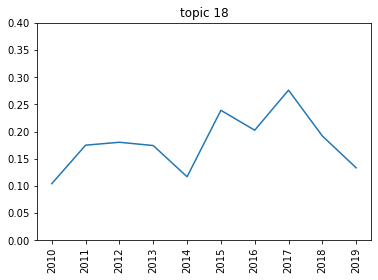

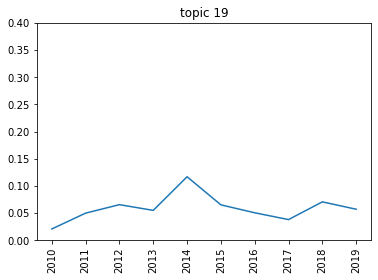

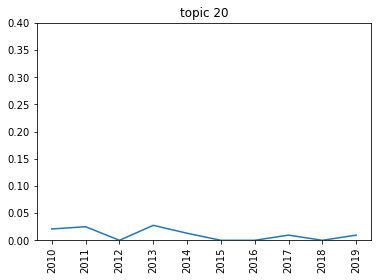

In [19]:
for topic in tmp:
    fig, ax = plt.subplots()
    plt.plot(years, tmp[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

In [23]:
check = test[test["topic"]==11]
check[check["year"] == 2017]["paragraph"].iloc[0].replace("WRAPTEXT", "")

' Brian Cornell  Well , thank you , John . Welcome , and thanks for joining us this morning .  Today , I ’ m going to provide an overview of our strategy . I ’ ll talk about  where we ’ ve been and more importantly , what ’ s next . John will share more  details about what we ’ re doing to get there , and then Cathy will walk  through our financial model . At the end of that , we ’ ll spend the balance of  the program taking your questions .  As you all know , we ’ ve been on a multi-year journey to redefine the future  of our company to compete and ultimately win in this new era of retail . For  the past several years , we ’ ve been watching several key consumer trends  emerge . People are placing greater value on experiences . Often they would  rather live it than own it , especially young people .  When they buy , they want to buy into a greater purpose , not just a product .  Taken together , these changes can only be described as a profound shift in  the consumer mindset . Then co

In [25]:
## search for certain key word
keyword = "shareholder"
check[check["paragraph"].map(lambda x: keyword in x)]

,paragraph,date,tokens,tokens_pos,tokens_clean,len_clean,corpus,topic,year
767,"WRAPTEXT San Francisco . And next year , we 'l...",2012-06-13,"[WRAPTEXT, San, Francisco, ., And, next, year,...","[(year, NN), (debut, VB), (open, VB), (locatio...","[debut, open, location, addition, investment, ...",168,"debut, open, location, addition, investment, r...",18,2012
999,WRAPTEXT Black Friday and in the days leading ...,2013-02-27,"[WRAPTEXT, Black, Friday, and, in, the, days, ...","[(days, NNS), (holiday, NN), (WRAPTEXT, VB), (...","[day, holiday, challenge, merchandising, team,...",361,"day, holiday, challenge, merchandising, team, ...",18,2013
1055,WRAPTEXT Gregg Steinhafel WRAPTEXT Good mornin...,2013-05-22,"[WRAPTEXT, Gregg, Steinhafel, WRAPTEXT, Good, ...","[(morning, NN), (welcome, VB), (quarter, NN), ...","[welcome, earnings, conference, call, line, to...",540,"welcome, earnings, conference, call, line, tod...",18,2013
1336,WRAPTEXT Thanksgiving Day . WRAPTEXT Throughou...,2013-11-02,"[WRAPTEXT, Thanksgiving, Day, ., WRAPTEXT, Thr...","[(season, NN), (merchandise, NN), (assortment,...","[season, merchandise, assortment, design, insp...",57,"season, merchandise, assortment, design, inspi...",18,2013
1658,"WRAPTEXT Brian Cornell WRAPTEXT Thanks , John ...",2014-11-19,"[WRAPTEXT, Brian, Cornell, WRAPTEXT, Thanks, ,...","[(morning, NN), (are, VBP), (quarter, NN), (pe...","[performance, announce, earnings, share, guida...",396,"performance, announce, earnings, share, guidan...",18,2014
1709,"WRAPTEXT Brian Cornell WRAPTEXT Greg , we 're ...",2014-11-19,"[WRAPTEXT, Brian, Cornell, WRAPTEXT, Greg, ,, ...","[('re, VBP), (think, VBP), (expect, VB), (be, ...","[expect, capability, continue, build, experien...",46,"expect, capability, continue, build, experienc...",18,2014
1877,WRAPTEXT Target Express store so far in our ho...,2015-03-05,"[WRAPTEXT, Target, Express, store, so, far, in...","[(store, NN), (hometown, NN), ('re, VBP), (res...","[hometown, result, continue, test, format, ope...",228,"hometown, result, continue, test, format, open...",18,2015
1894,"WRAPTEXT Brian Cornell WRAPTEXT Well , I think...",2015-03-05,"[WRAPTEXT, Brian, Cornell, WRAPTEXT, Well, ,, ...","[(think, VBP), (is, VBZ), (questions, NNS), (l...","[let, tease, one, receive, shareholder, leader...",179,"let, tease, one, receive, shareholder, leaders...",18,2015
1941,"WRAPTEXT Brian C. Cornell - Chairman , Preside...",2015-05-20,"[WRAPTEXT, Brian, C., Cornell, -, Chairman, ,,...","[(morning, NN), ('re, VBP), (quarter, NN), (re...","[result, announce, adjust, high-end, range, pr...",707,"result, announce, adjust, high-end, range, pro...",18,2015
2025,"WRAPTEXT Brian Cornell WRAPTEXT Thanks , John ...",2015-08-19,"[WRAPTEXT, Brian, Cornell, WRAPTEXT, Thanks, ,...","[(morning, NN), (are, VBP), (quarter, NN), (re...","[result, announce, adjust, end, guidance, rang...",533,"result, announce, adjust, end, guidance, range...",18,2015


## Interactive visualization

In [26]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

Wall time: 46.3 s


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [27]:
pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.025372 -0.101845       1        1  17.803035
17    -0.009535 -0.090510       2        1  17.572286
12    -0.187053 -0.034748       3        1  11.387386
16     0.021307 -0.178021       4        1   9.770781
18    -0.215314  0.010866       5        1   8.461240
9     -0.247372  0.034610       6        1   8.166846
1     -0.189075  0.025767       7        1   4.155135
7      0.115472 -0.112069       8        1   3.999468
10    -0.028316 -0.106085       9        1   2.909774
6      0.084001 -0.022045      10        1   2.806852
0     -0.090376  0.209628      11        1   2.633287
11    -0.084844 -0.001429      12        1   2.042781
13     0.077640 -0.104219      13        1   1.813177
19     0.090865 -0.068497      14        1   1.638207
5      0.088873  0.001031      15        1   1.254197
8      0.116767  0.047518      16        1   1.191490
4      0.067641  0.058119      17        1   0.715727
15     0.117809  0.108680      18        1   0.602378
2      0.106091  0.233518      19        1   0.570058
3      0.140047  0.089732      20        1   0.505894, topic_info=     Category         Freq          Term        Total  loglift  logprob
1743  Default  1961.000000         guest  1961.000000  30.0000  30.0000
3342  Default  1694.000000          sale  1694.000000  29.0000  29.0000
437   Default   808.000000         brand   808.000000  28.0000  28.0000
3404  Default   409.000000       segment   409.000000  27.0000  27.0000
840   Default  1415.000000      continue  1415.000000  26.0000  26.0000
3851  Default  1207.000000          team  1207.000000  25.0000  25.0000
1580  Default   291.000000          food   291.000000  24.0000  24.0000
562   Default   931.000000      category   931.000000  23.0000  23.0000
1431  Default  1013.000000        expect  1013.000000  22.0000  22.0000
2892  Default   518.000000       product   518.000000  21.0000  21.0000
245   Default   459.000000    assortment   459.000000  20.0000  20.0000
2285  Default   591.000000        margin   591.000000  19.0000  19.0000
2994  Default   659.000000          rate   659.000000  18.0000  18.0000
2564  Default   280.000000         order   280.000000  17.0000  17.0000
2861  Default   377.000000         price   377.000000  16.0000  16.0000
2707  Default   794.000000   performance   794.000000  15.0000  15.0000
886   Default   285.000000          cost   285.000000  14.0000  14.0000
1836  Default   298.000000          home   298.000000  13.0000  13.0000
2053  Default   476.000000          item   476.000000  12.0000  12.0000
1636  Default   253.000000   fulfillment   253.000000  11.0000  11.0000
587   Default   294.000000         chain   294.000000  10.0000  10.0000
3427  Default   332.000000       service   332.000000   9.0000   9.0000
1928  Default   644.000000      increase   644.000000   8.0000   8.0000
1440  Default   648.000000    experience   648.000000   7.0000   7.0000
1439  Default   417.000000       expense   417.000000   6.0000   6.0000
3442  Default   650.000000         share   650.000000   5.0000   5.0000
3781  Default   267.000000        supply   267.000000   4.0000   4.0000
4112  Default   360.000000         value   360.000000   3.0000   3.0000
1741  Default   882.000000        growth   882.000000   2.0000   2.0000
2031  Default   561.000000    investment   561.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1599  Topic20     1.495031     formation     5.173613   4.0452  -5.8221
3921  Topic20     1.495031          time     5.218597   4.0365  -5.8221
140   Topic20     1.458229   alternative     5.182189   4.0186  -5.8471
1769  Topic20     5.555095        happen    59.493423   2.9154  -4.5096
1763  Topic20     1.477783       handful     6.236182   3.8468  -5.8337
1516  Topic20     1.105742          file     3.482943   4.1392  -6.1238
2861  Topic20    10.104473       

## Visualize components for each year (stop using for now)

IndexError: list index out of range

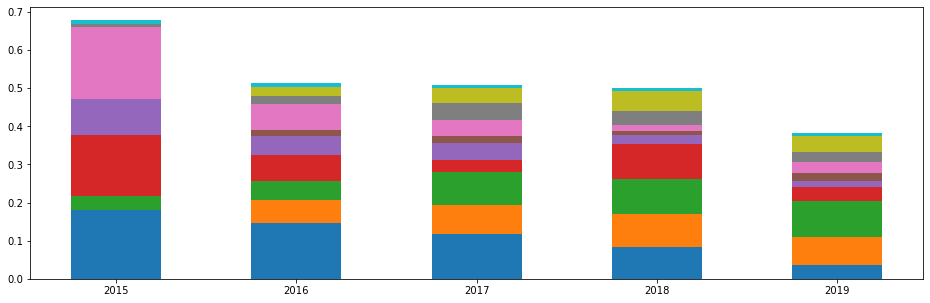

In [144]:
# event_tp = df.groupby(by=["year","topic"])["topic"].count().unstack().fillna(0)
# tmp = event_tp.T.apply(sum)
# event_tp = event_tp.apply(lambda x: x/tmp)
# event_tp.index = [str(x)[:10] for x in event_tp.index]

# fig, ax = plt.subplots(figsize=(16, 5))
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
#           'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# bottom = np.array([0]*event_tp.shape[0])
# x = event_tp.index.values

# for i in event_tp.columns:
# #     print(event_tp[i].values)
#     plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
#     bottom = bottom + event_tp[i]

# plt.legend(event_tp.columns)
# plt.title("Topic distribution across events")